In [93]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import pandas as pd
import numpy as np
import re

#Text representation and transformation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

#Validation
from sklearn.model_selection import train_test_split

# classifiers algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

### 1. EDA

In [94]:
# Load the train and test datasets
df = pd.read_csv("Dataset/train_preprocessed.csv")
df_test = pd.read_csv("Dataset/test_preprocessed.csv")
df.head()

,comment_text,id,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity
0,explanation why the edits made under my userna...,0000997932d777bf,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
1,d aww he matches this background colour i m s...,000103f0d9cfb60f,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
2,hey man i m really not trying to edit war it...,000113f07ec002fd,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
3,more i can t make any real suggestions on im...,0001b41b1c6bb37e,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
4,you sir are my hero any chance you remember...,0001d958c54c6e35,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0


In [95]:
df.shape

(159571, 10)

In [96]:
df_test.shape

(153164, 10)

In [97]:
df = df.drop(['id','set','toxicity'], axis=1)
labels = list(df.columns)
labels.remove('comment_text')

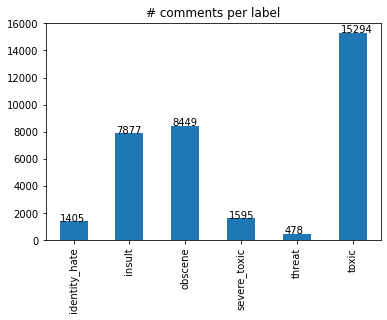

In [98]:
ax = df[labels].sum(axis=0).plot(kind='bar', title='# comments per label');
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.01, p.get_height() * 1.001))

Text(0.5, 0, '# of categories')

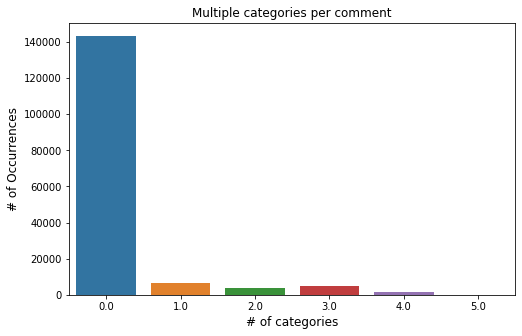

In [99]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [100]:
print('Percentage of comments that are not labelled:')
print(len(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']== 0) & (df['insult']==0) & (df['identity_hate']==0)]) / len(df))

Percentage of comments that are not labelled:
0.8983211235124177


<AxesSubplot:>

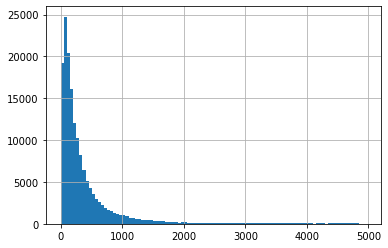

In [101]:
lens = df.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

### 2. Preprocessing (data preparation)

In [102]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

(106912,)
(52659,)


### 3. Model Learning

#### 3.1 Naive Bayes

... Processing toxic
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     47576
         1.0       0.99      0.19      0.32      5083

    accuracy                           0.92     52659
   macro avg       0.95      0.60      0.64     52659
weighted avg       0.93      0.92      0.90     52659



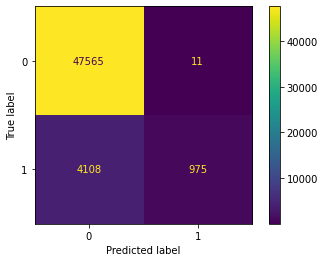

... Processing severe_toxic
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     52133
         1.0       0.00      0.00      0.00       526

    accuracy                           0.99     52659
   macro avg       0.50      0.50      0.50     52659
weighted avg       0.98      0.99      0.99     52659



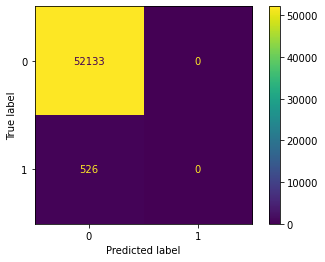

... Processing obscene
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98     49828
         1.0       0.99      0.12      0.21      2831

    accuracy                           0.95     52659
   macro avg       0.97      0.56      0.59     52659
weighted avg       0.95      0.95      0.93     52659



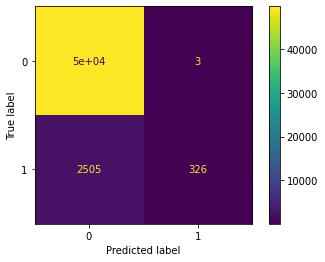

... Processing threat
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     52507
         1.0       0.00      0.00      0.00       152

    accuracy                           1.00     52659
   macro avg       0.50      0.50      0.50     52659
weighted avg       0.99      1.00      1.00     52659



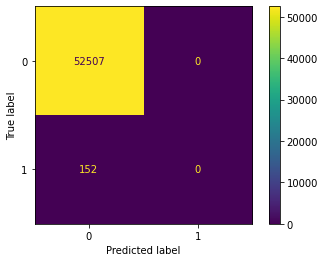

... Processing insult
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98     50016
         1.0       0.95      0.05      0.09      2643

    accuracy                           0.95     52659
   macro avg       0.95      0.52      0.53     52659
weighted avg       0.95      0.95      0.93     52659



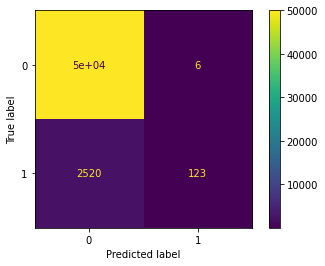

... Processing identity_hate
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     52188
         1.0       0.00      0.00      0.00       471

    accuracy                           0.99     52659
   macro avg       0.50      0.50      0.50     52659
weighted avg       0.98      0.99      0.99     52659



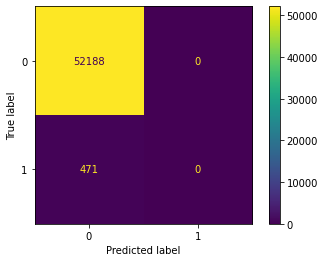

In [103]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
train_accuracy = []
train_score_list = []
test_accuracy = []
score_list = []
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    
    # compute the training accuracy
    pred_train = NB_pipeline.predict(X_train)
    train_accuracy.append(accuracy_score(train[category], pred_train))
    train_score = f1_score(train[category], pred_train)
    train_score_list.append(train_score)
    
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    test_accuracy.append(accuracy_score(test[category], prediction))
    score= f1_score(test[category], prediction)
    score_list.append(score)
    cm = confusion_matrix(test[category], prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    print(classification_report(test[category], prediction))
    plt.show()
df_metrics_nb = pd.DataFrame(list(zip(test_accuracy, score_list)),
               columns =['Test Accuracy', 'F1 Score'])
df_train_metrics_nb = pd.DataFrame(list(zip(train_accuracy, train_score_list)),
               columns =['Train Accuracy', 'F1 Score'])  

In [104]:
# NB train score
print(df_train_metrics_nb)

   Train Accuracy  F1 Score
0        0.927613  0.391445
1        0.989954  0.000000
2        0.955421  0.266318
3        0.996932  0.000000
4        0.954477  0.136904
5        0.991217  0.000000


In [105]:
# NB test score
print(df_metrics_nb)

   Test Accuracy  F1 Score
0       0.921780  0.321305
1       0.990011  0.000000
2       0.952373  0.206329
3       0.997114  0.000000
4       0.952031  0.088745
5       0.991056  0.000000


#### 3.2 KNN

... Processing toxic
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     47576
         1.0       0.91      0.18      0.30      5083

    accuracy                           0.92     52659
   macro avg       0.91      0.59      0.63     52659
weighted avg       0.92      0.92      0.89     52659



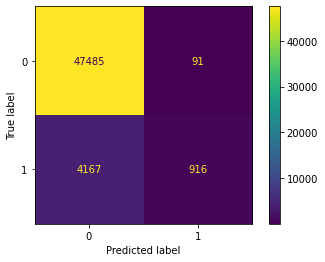

... Processing severe_toxic
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     52133
         1.0       0.40      0.17      0.24       526

    accuracy                           0.99     52659
   macro avg       0.69      0.58      0.62     52659
weighted avg       0.99      0.99      0.99     52659



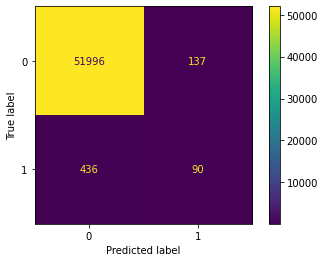

... Processing obscene
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     49828
         1.0       0.88      0.24      0.38      2831

    accuracy                           0.96     52659
   macro avg       0.92      0.62      0.68     52659
weighted avg       0.95      0.96      0.95     52659



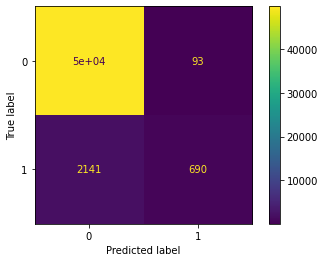

... Processing threat
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     52507
         1.0       0.50      0.05      0.08       152

    accuracy                           1.00     52659
   macro avg       0.75      0.52      0.54     52659
weighted avg       1.00      1.00      1.00     52659



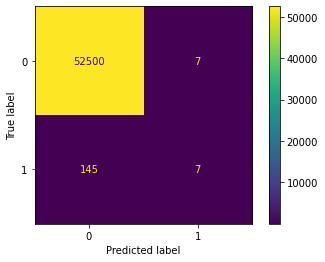

... Processing insult
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     50016
         1.0       0.79      0.21      0.33      2643

    accuracy                           0.96     52659
   macro avg       0.88      0.60      0.65     52659
weighted avg       0.95      0.96      0.95     52659



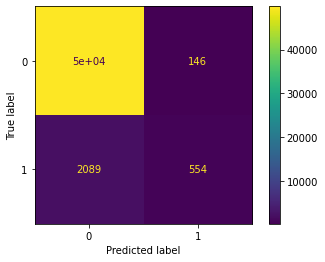

... Processing identity_hate
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     52188
         1.0       0.72      0.10      0.18       471

    accuracy                           0.99     52659
   macro avg       0.85      0.55      0.59     52659
weighted avg       0.99      0.99      0.99     52659



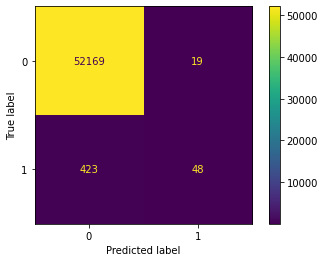

In [106]:
# KNN pipeline
KNN_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(KNeighborsClassifier())),
            ])

knn_train_accuracy = []
knn_train_score_list =[]

knn_test_accuracy = []
knn_score_list = []
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    KNN_pipeline.fit(X_train, train[category])
    
    # compute the training accuracy
    pred_train = KNN_pipeline.predict(X_train)
    knn_train_accuracy.append(accuracy_score(train[category], pred_train))
    knn_train_score = f1_score(train[category], pred_train)
    knn_train_score_list.append(knn_train_score)
    
    # compute the testing accuracy
    prediction = KNN_pipeline.predict(X_test)
    knn_test_accuracy.append(accuracy_score(test[category], prediction))
    score= f1_score(test[category], prediction)
    knn_score_list.append(score)
    cm = confusion_matrix(test[category], prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    print(classification_report(test[category], prediction))
    plt.show()
df_metrics_knn = pd.DataFrame(list(zip(knn_test_accuracy, knn_score_list)),
               columns =['Test Accuracy', 'F1 Score'])
df_train_metrics_knn = pd.DataFrame(list(zip(knn_train_accuracy, knn_train_score_list)),
               columns =['Train Accuracy', 'F1 Score'])  

In [107]:
# KNN train score
print(df_train_metrics_knn)

   Train Accuracy  F1 Score
0        0.923086  0.339147
1        0.991320  0.380507
2        0.959958  0.405664
3        0.997091  0.113960
4        0.960500  0.368665
5        0.991937  0.172745


In [108]:
# KNN test score
print(df_metrics_knn)

   Test Accuracy  F1 Score
0       0.919140  0.300821
1       0.989119  0.239044
2       0.957576  0.381848
3       0.997114  0.084337
4       0.957557  0.331439
5       0.991606  0.178439


#### 3.3 Decision Tree

... Processing toxic
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     47576
         1.0       0.70      0.69      0.69      5083

    accuracy                           0.94     52659
   macro avg       0.83      0.83      0.83     52659
weighted avg       0.94      0.94      0.94     52659



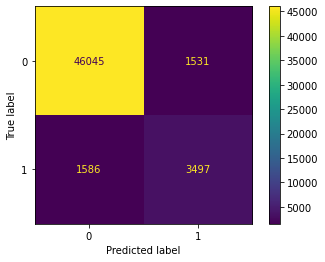

... Processing severe_toxic
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     52133
         1.0       0.34      0.27      0.30       526

    accuracy                           0.99     52659
   macro avg       0.66      0.63      0.65     52659
weighted avg       0.99      0.99      0.99     52659



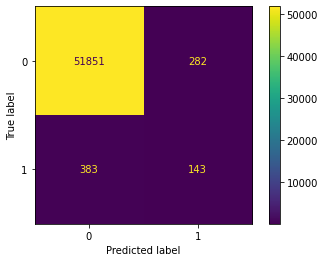

... Processing obscene
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     49828
         1.0       0.76      0.76      0.76      2831

    accuracy                           0.97     52659
   macro avg       0.87      0.87      0.87     52659
weighted avg       0.97      0.97      0.97     52659



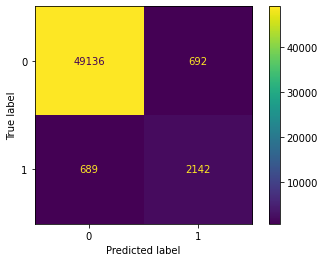

... Processing threat
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     52507
         1.0       0.33      0.29      0.31       152

    accuracy                           1.00     52659
   macro avg       0.66      0.64      0.65     52659
weighted avg       1.00      1.00      1.00     52659



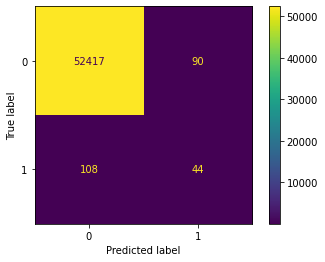

... Processing insult
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     50016
         1.0       0.63      0.61      0.62      2643

    accuracy                           0.96     52659
   macro avg       0.80      0.80      0.80     52659
weighted avg       0.96      0.96      0.96     52659



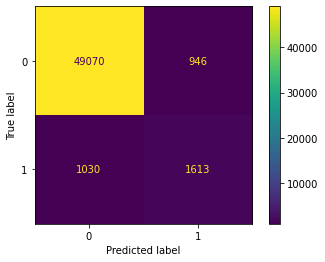

... Processing identity_hate
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     52188
         1.0       0.45      0.36      0.40       471

    accuracy                           0.99     52659
   macro avg       0.72      0.68      0.70     52659
weighted avg       0.99      0.99      0.99     52659



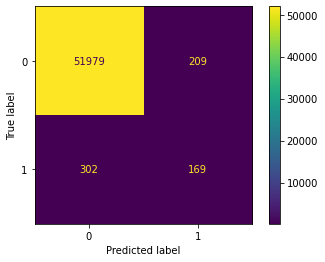

In [109]:
# Decision Tree pipeline
DT_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(DecisionTreeClassifier())),
            ])

dt_train_accuracy = []
dt_train_score_list = []

dt_test_accuracy = []
dt_score_list = []
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    DT_pipeline.fit(X_train, train[category])
    
    # compute the training accuracy
    pred_train = DT_pipeline.predict(X_train)
    dt_train_accuracy.append(accuracy_score(train[category], pred_train))
    dt_train_score = f1_score(train[category], pred_train)
    dt_train_score_list.append(dt_train_score)
    
    # compute the testing accuracy
    prediction = DT_pipeline.predict(X_test)
    dt_test_accuracy.append(accuracy_score(test[category], prediction))
    score= f1_score(test[category], prediction)
    dt_score_list.append(score)
    cm = confusion_matrix(test[category], prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    print(classification_report(test[category], prediction))
    plt.show()
df_metrics_dt = pd.DataFrame(list(zip(dt_test_accuracy, dt_score_list)),
               columns =['Test Accuracy', 'F1 Score'])
df_train_metrics_dt = pd.DataFrame(list(zip(dt_train_accuracy, dt_train_score_list)),
               columns =['Train Accuracy', 'F1 Score'])

In [110]:
# DT train score
print(df_train_metrics_dt)

   Train Accuracy  F1 Score
0        0.999710  0.998480
1        0.999645  0.981956
2        0.999673  0.996878
3        0.999935  0.989214
4        0.999448  0.994350
5        0.999869  0.992457


In [111]:
# DT test score
print(df_metrics_dt)

   Test Accuracy  F1 Score
0       0.940808  0.691722
1       0.987372  0.300736
2       0.973775  0.756222
3       0.996240  0.307692
4       0.962476  0.620146
5       0.990296  0.398115


#### 3.4 Logistic Regression

... Processing toxic
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     47576
         1.0       0.91      0.61      0.73      5083

    accuracy                           0.96     52659
   macro avg       0.94      0.80      0.85     52659
weighted avg       0.96      0.96      0.95     52659



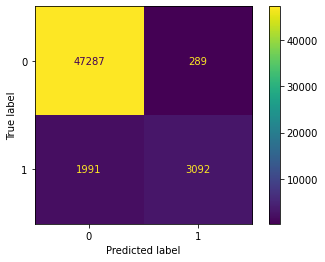

... Processing severe_toxic
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     52133
         1.0       0.56      0.28      0.37       526

    accuracy                           0.99     52659
   macro avg       0.78      0.64      0.68     52659
weighted avg       0.99      0.99      0.99     52659



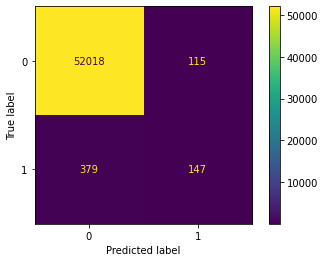

... Processing obscene
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     49828
         1.0       0.91      0.67      0.77      2831

    accuracy                           0.98     52659
   macro avg       0.95      0.83      0.88     52659
weighted avg       0.98      0.98      0.98     52659



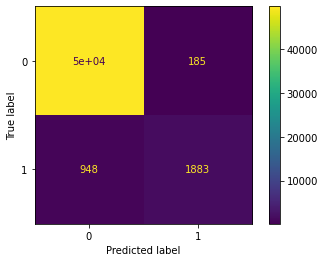

... Processing threat
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     52507
         1.0       0.76      0.17      0.28       152

    accuracy                           1.00     52659
   macro avg       0.88      0.59      0.64     52659
weighted avg       1.00      1.00      1.00     52659



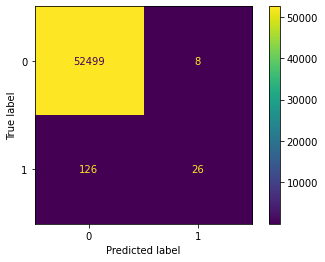

... Processing insult
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     50016
         1.0       0.82      0.52      0.64      2643

    accuracy                           0.97     52659
   macro avg       0.90      0.76      0.81     52659
weighted avg       0.97      0.97      0.97     52659



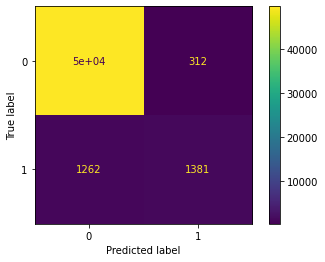

... Processing identity_hate
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     52188
         1.0       0.69      0.19      0.29       471

    accuracy                           0.99     52659
   macro avg       0.84      0.59      0.65     52659
weighted avg       0.99      0.99      0.99     52659



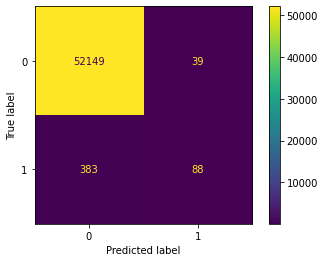

In [112]:
# Logistic Regression Pipeline
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
lgr_train_accuracy =[]
lgr_train_score_list = []

lgr_test_accuracy = []
lgr_score_list = []
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    
    # compute the training accuracy
    pred_train = LogReg_pipeline.predict(X_train)
    lgr_train_accuracy.append(accuracy_score(train[category], pred_train))
    lgr_train_score = f1_score(train[category], pred_train)
    lgr_train_score_list.append(lgr_train_score)
    
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    lgr_test_accuracy.append(accuracy_score(test[category], prediction))
    score= f1_score(test[category], prediction)
    lgr_score_list.append(score)
    cm = confusion_matrix(test[category], prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    print(classification_report(test[category], prediction))
    plt.show()
df_metrics_logre = pd.DataFrame(list(zip(lgr_test_accuracy, lgr_score_list)),
               columns =['Test Accuracy', 'F1 Score']) 
df_train_metrics_lgr = pd.DataFrame(list(zip(lgr_train_accuracy, lgr_train_score_list)),
               columns =['Train Accuracy', 'F1 Score'])

In [113]:
# Log Reg train score
print(df_train_metrics_lgr)

   Train Accuracy  F1 Score
0        0.962521  0.767103
1        0.991067  0.392880
2        0.981031  0.794028
3        0.997157  0.182796
4        0.973548  0.673667
5        0.992508  0.322908


In [114]:
# Log Reg. test score
print(df_metrics_logre)

   Test Accuracy  F1 Score
0       0.956703  0.730624
1       0.990619  0.373096
2       0.978484  0.768728
3       0.997455  0.279570
4       0.970110  0.636993
5       0.991986  0.294314


#### 3.5 RandomForest

... Processing toxic
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     47576
         1.0       0.91      0.60      0.72      5083

    accuracy                           0.96     52659
   macro avg       0.93      0.79      0.85     52659
weighted avg       0.95      0.96      0.95     52659



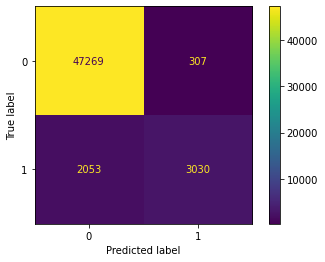

... Processing severe_toxic
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     52133
         1.0       0.46      0.06      0.10       526

    accuracy                           0.99     52659
   macro avg       0.73      0.53      0.55     52659
weighted avg       0.99      0.99      0.99     52659



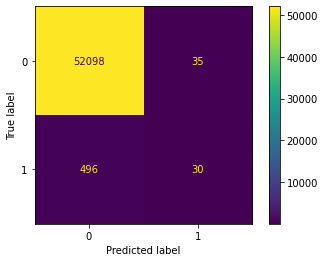

... Processing obscene
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     49828
         1.0       0.89      0.67      0.77      2831

    accuracy                           0.98     52659
   macro avg       0.94      0.83      0.88     52659
weighted avg       0.98      0.98      0.98     52659



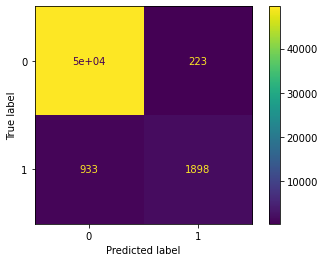

... Processing threat
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     52507
         1.0       0.60      0.06      0.11       152

    accuracy                           1.00     52659
   macro avg       0.80      0.53      0.55     52659
weighted avg       1.00      1.00      1.00     52659



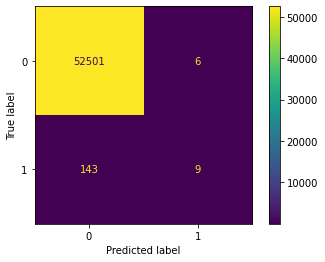

... Processing insult
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     50016
         1.0       0.80      0.49      0.61      2643

    accuracy                           0.97     52659
   macro avg       0.89      0.74      0.80     52659
weighted avg       0.97      0.97      0.96     52659



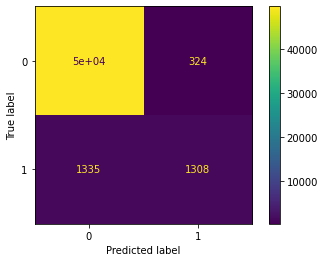

... Processing identity_hate
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     52188
         1.0       0.80      0.07      0.13       471

    accuracy                           0.99     52659
   macro avg       0.90      0.53      0.56     52659
weighted avg       0.99      0.99      0.99     52659



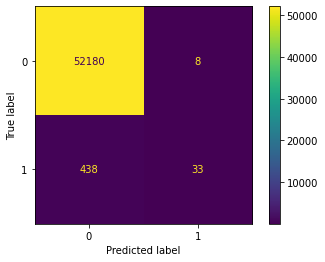

In [115]:
# RandomForest Pipeline
RandomForest_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(RandomForestClassifier(), n_jobs=1)),
            ])
rf_train_accuracy = []
rf_train_score_list = []

rf_test_accuracy = []
rf_score_list = []
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    RandomForest_pipeline.fit(X_train, train[category])
    
    # compute the training accuracy
    pred_train = RandomForest_pipeline.predict(X_train)
    rf_train_accuracy.append(accuracy_score(train[category], pred_train))
    rf_train_score = f1_score(train[category], pred_train)
    rf_train_score_list.append(rf_train_score)
    
    # compute the testing accuracy
    prediction = RandomForest_pipeline.predict(X_test)
    rf_test_accuracy.append(accuracy_score(test[category], prediction))
    score= f1_score(test[category], prediction)
    rf_score_list.append(score)
    cm = confusion_matrix(test[category], prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    print(classification_report(test[category], prediction))
    plt.show()
df_metrics_rf = pd.DataFrame(list(zip(rf_test_accuracy, rf_score_list)),
               columns =['Test Accuracy', 'F1 Score'])
df_train_metrics_rf = pd.DataFrame(list(zip(rf_train_accuracy, rf_train_score_list)),
               columns =['Train Accuracy', 'F1 Score'])

In [116]:
# RF train score
print(df_train_metrics_rf)

   Train Accuracy  F1 Score
0        0.999701  0.998432
1        0.999645  0.981991
2        0.999663  0.996791
3        0.999935  0.989214
4        0.999448  0.994365
5        0.999869  0.992481


In [117]:
# RF test score
print(df_metrics_rf)

   Test Accuracy  F1 Score
0       0.955183  0.719715
1       0.989916  0.101523
2       0.978047  0.766559
3       0.997170  0.107784
4       0.968495  0.611930
5       0.991530  0.128906


### 4. Final prediction

In [118]:
df_test.head()

,comment_text,id,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity
0,yo bitch ja rule is more succesful then you ll...,00001cee341fdb12,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN
1,from rfc the title is fine as it is imo,0000247867823ef7,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN
2,sources zawe ashton on lapland,00013b17ad220c46,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN
3,if you have a look back at the source the in...,00017563c3f7919a,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN
4,i don t anonymously edit articles at all,00017695ad8997eb,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN


In [119]:
df_test = df_test.drop(['id','set','toxicity'], axis=1)

In [120]:
print(np.sum(df_test.comment_text.isnull()))

15


In [121]:
df_final = df_test.dropna(subset=['comment_text'])

In [122]:
print(np.sum(df_final.comment_text.isnull()))

0


In [123]:
df_final_cls = df_final.copy(deep=True)

In [124]:
y_preds_proba = LogReg_pipeline.predict_proba(df_final.comment_text)

In [125]:
print(y_preds_proba)

[[0.84420976 0.15579024]
 [0.99620335 0.00379665]
 [0.99530504 0.00469496]
 ...
 [0.99837303 0.00162697]
 [0.98898577 0.01101423]
 [0.98765679 0.01234321]]


In [126]:
y_preds = LogReg_pipeline.predict(df_final_cls.comment_text)

In [127]:
print(y_preds)

[0. 0. 0. ... 0. 0. 0.]


In [128]:
for idx,cat in enumerate(categories):
    df_final[cat] = y_preds_proba[:,1]
    df_final_cls[cat] = y_preds[idx]

In [129]:
df_final.head(10)

,comment_text,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,yo bitch ja rule is more succesful then you ll...,0.155790,0.155790,0.155790,0.155790,0.155790,0.155790
1,from rfc the title is fine as it is imo,0.003797,0.003797,0.003797,0.003797,0.003797,0.003797
2,sources zawe ashton on lapland,0.004695,0.004695,0.004695,0.004695,0.004695,0.004695
3,if you have a look back at the source the in...,0.001364,0.001364,0.001364,0.001364,0.001364,0.001364
4,i don t anonymously edit articles at all,0.003207,0.003207,0.003207,0.003207,0.003207,0.003207
5,thank you for understanding i think very high...,0.001393,0.001393,0.001393,0.001393,0.001393,0.001393
6,please do not add nonsense to wikipedia such ...,0.001024,0.001024,0.001024,0.001024,0.001024,0.001024
7,dear god this site is horrible,0.006255,0.006255,0.006255,0.006255,0.006255,0.006255
8,only a fool can believe in such numbers the ...,0.004056,0.004056,0.004056,0.004056,0.004056,0.004056
9,double redirects when fixing double redirects...,0.002854,0.002854,0.002854,0.002854,0.002854,0.002854


In [130]:
df_final_cls.head(10)

,comment_text,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,yo bitch ja rule is more succesful then you ll...,0.0,0.0,0.0,0.0,0.0,0.0
1,from rfc the title is fine as it is imo,0.0,0.0,0.0,0.0,0.0,0.0
2,sources zawe ashton on lapland,0.0,0.0,0.0,0.0,0.0,0.0
3,if you have a look back at the source the in...,0.0,0.0,0.0,0.0,0.0,0.0
4,i don t anonymously edit articles at all,0.0,0.0,0.0,0.0,0.0,0.0
5,thank you for understanding i think very high...,0.0,0.0,0.0,0.0,0.0,0.0
6,please do not add nonsense to wikipedia such ...,0.0,0.0,0.0,0.0,0.0,0.0
7,dear god this site is horrible,0.0,0.0,0.0,0.0,0.0,0.0
8,only a fool can believe in such numbers the ...,0.0,0.0,0.0,0.0,0.0,0.0
9,double redirects when fixing double redirects...,0.0,0.0,0.0,0.0,0.0,0.0
